Change it to active block channel + not active block channel

Also, change mnist to discrete values. 

I NEED TO READ THIS. Look for how binomial difusion was done
https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.schedulers.scheduling_utils import SchedulerMixin

import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Had an issue with pytorch bernouli noise. Trying to redo it, just getting the noise working

In [2]:
from torch.utils.data import TensorDataset

# Device configuration
noiseDevice = 'cpu'

image_size = 32
image = torch.zeros((8, 1, image_size, image_size), device=noiseDevice)
image[:, :, 8:24, 8:24] = 1.0

dataset = TensorDataset(image)
trainDataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
trainSteps = 100
betas = torch.linspace(0.0001, 0.015, 100, device=noiseDevice) # The last value of alpha_cumprod should be close to 0.5
alphas = 1.0 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)

# print(betas)
# print(alphas)
# print(alpha_cumprod)    

In [4]:
# def addBernouliNoise(imageBatch, time):
#     with torch.no_grad():
#         alpha_t = alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)
#         noise = torch.randint(0, 2, imageBatch.shape, device=noiseDevice)
#         noisedImages = torch.sqrt(alpha_t) * imageBatch + torch.sqrt(1 - alpha_t) * noise
#         return noisedImages, noise

def addBernouliNoise(imageBatch, time):
    with torch.no_grad():
        alpha_t = alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

        # Compute the flip probability (beta_t = 1 - alpha_t)
        beta_t = 1 - alpha_t
        probabilities = beta_t.expand_as(imageBatch)

        # Generate a binary noise mask with probability beta_t
        noise_mask = torch.bernoulli(probabilities).to(imageBatch.device)

        # Flip the bits in the image using the noise mask (XOR operation)
        noisedImages = imageBatch * (1 - noise_mask) + (1 - imageBatch) * noise_mask
        return noisedImages, probabilities



data_iter = iter(trainDataloader)
batch = next(data_iter)[0] 

# addBernouliNoise(batch, torch.tensor(99).long())
# print()

In [5]:
torch.set_printoptions(threshold=torch.inf)

In [6]:
#torch.bernoulli(torch.tensor((0.0, 0.5)))
torch.sigmoid(torch.tensor((1.0, 2.0, 3.0, 0.0)))

tensor([0.7311, 0.8808, 0.9526, 0.5000])

In [7]:
#This feels incorrect, but lets just try it.
def denoise(predictedProb, time, x):
    alpha_t = alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)
    # Compute the flip probability (beta_t = 1 - alpha_t)
    beta_t = (1 - alpha_t).to(x.device)

    noise_mask = torch.bernoulli(predictedProb).to(x.device)

     # Estimate the probability that each bit was originally 1
    #p_original_1 = x * (1 - predictedProb) + (1 - x) * predictedProb
    p_original_1 = x * (1 - noise_mask) + (1 - x) * noise_mask

    # If we imagine the number beta, as the amount of 
    print(beta_t)
    
    
    # Adjust the estimate using the noise schedule (beta_t)
    prev_x = p_original_1 * (1 - beta_t) + (1 - p_original_1) * beta_t
    
    # Return the expected value of x_{t-1}
    return prev_x

timeStep = torch.tensor(0).long()
noisyImg, noise = addBernouliNoise(batch, timeStep)
# print(torch. softmax(noise.float(), dim=0))
denoise(noise, timeStep, noisyImg)
print()

tensor([[[[0.0001]]]])



In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model = UNet2DModel(
    sample_size=image_size,   # image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 64, 64),
    down_block_types=( 
        "DownBlock2D",    
        "DownBlock2D",   
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "UpBlock2D",   
        "UpBlock2D",        
    ),
).to(device)

Using device: cuda


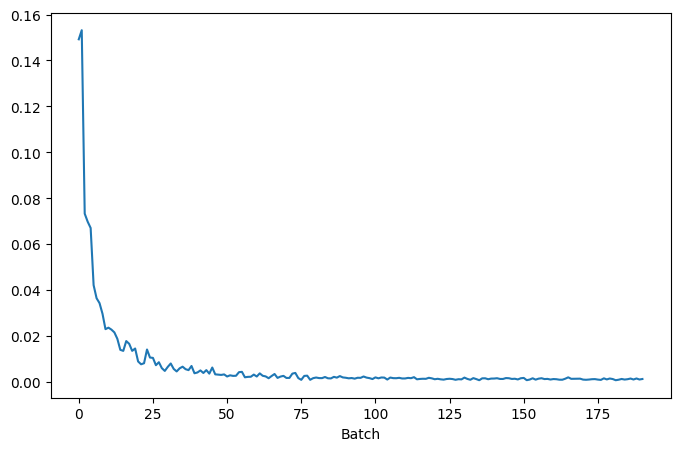

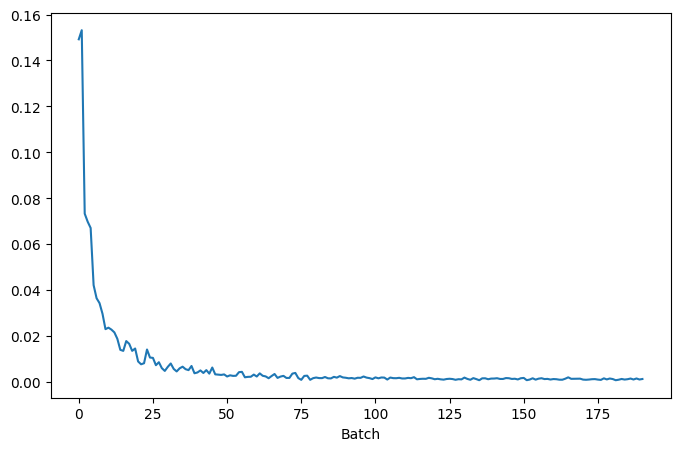

In [9]:
PLOTUPDATES = True
updateRate = 10
n_epochs = 200

opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

# class MSEPerChannelSum(nn.Module):
#     def forward(self, X_pred, X_true):
#         squared_errors = (X_pred - X_true) ** 2  # Squared differences
#         mean_per_channel = squared_errors.mean(dim=[0, 2, 3])  # Mean per channel
#         return mean_per_channel.sum()  # Sum over all channels
    
loss_fn = nn.MSELoss()
losses = []

if PLOTUPDATES:
    fig, ax = plt.subplots(figsize=(8, 5))
    display(fig)

for epoch in range(n_epochs):
    
    #for image, label in tqdm(trainDataloader):
    for image in trainDataloader:
        image = image[0] #Image is a list 
        #label = label.to(device)

        timesteps = torch.randint(0, trainSteps - 1, (image.shape[0],), device='cpu').long()

        noisyImg, noise = addBernouliNoise(batch, timesteps)

        pred = model(noisyImg.to(device), timesteps.to(device)).sample
        loss = loss_fn(pred, noise.to(device)) # How close is the output to the noise
        #loss = torch.nn.functional.cross_entropy(noise, pred.argmax(dim=1))

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if PLOTUPDATES:
        if epoch % updateRate == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(losses)
            plt.xlabel('Batch')
            display(fig)

In [116]:
#Redifine denoising

def denoise(x_t, time, predicted_noise):
    with torch.no_grad():
        # Get α_t and α_{t-1} from the schedule
        alpha_t = alpha_cumprod[time].view(-1, 1, 1, 1)
        alpha_t_prev = alpha_cumprod[time - 1].view(-1, 1, 1, 1) if time > 0 else torch.ones_like(alpha_t)
        
        # Compute the coefficients for x_t and predicted noise
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Reconstruct x_0 from x_t and predicted noise
        x_0 = (x_t - sqrt_one_minus_alpha_t * predicted_noise) / sqrt_alpha_t
        
        # Clip x_0 to valid range (0 or 1 for binary images)
        x_0 = torch.clamp(x_0, 0, 1)
        
        # Compute x_{t-1} using x_0 and the reverse process
        sqrt_alpha_t_prev = torch.sqrt(alpha_t_prev)
        sqrt_one_minus_alpha_t_prev = torch.sqrt(1 - alpha_t_prev)
        
        # Sample x_{t-1} using the reverse process
        mean = sqrt_alpha_t_prev * x_0 + sqrt_one_minus_alpha_t_prev * predicted_noise
        x_t_minus_1 = torch.bernoulli(mean)  # Sample binary values
        
        return x_t_minus_1

  2%|▏         | 2/100 [00:00<00:05, 18.48it/s]

tensor([[[[0.5318]]]], device='cuda:0')
tensor([[[[0.5247]]]], device='cuda:0')
tensor([[[[0.5175]]]], device='cuda:0')
tensor([[[[0.5103]]]], device='cuda:0')
tensor([[[[0.5031]]]], device='cuda:0')
tensor([[[[0.4958]]]], device='cuda:0')


 33%|███▎      | 33/100 [00:00<00:00, 93.62it/s]

tensor([[[[0.4885]]]], device='cuda:0')
tensor([[[[0.4812]]]], device='cuda:0')
tensor([[[[0.4739]]]], device='cuda:0')
tensor([[[[0.4665]]]], device='cuda:0')
tensor([[[[0.4591]]]], device='cuda:0')
tensor([[[[0.4517]]]], device='cuda:0')
tensor([[[[0.4443]]]], device='cuda:0')
tensor([[[[0.4369]]]], device='cuda:0')
tensor([[[[0.4294]]]], device='cuda:0')
tensor([[[[0.4220]]]], device='cuda:0')
tensor([[[[0.4145]]]], device='cuda:0')
tensor([[[[0.4071]]]], device='cuda:0')
tensor([[[[0.3996]]]], device='cuda:0')
tensor([[[[0.3921]]]], device='cuda:0')
tensor([[[[0.3846]]]], device='cuda:0')
tensor([[[[0.3772]]]], device='cuda:0')
tensor([[[[0.3697]]]], device='cuda:0')
tensor([[[[0.3623]]]], device='cuda:0')
tensor([[[[0.3548]]]], device='cuda:0')
tensor([[[[0.3474]]]], device='cuda:0')
tensor([[[[0.3400]]]], device='cuda:0')
tensor([[[[0.3326]]]], device='cuda:0')
tensor([[[[0.3252]]]], device='cuda:0')
tensor([[[[0.3178]]]], device='cuda:0')
tensor([[[[0.3105]]]], device='cuda:0')


 63%|██████▎   | 63/100 [00:00<00:00, 120.53it/s]

tensor([[[[0.2601]]]], device='cuda:0')
tensor([[[[0.2530]]]], device='cuda:0')
tensor([[[[0.2460]]]], device='cuda:0')
tensor([[[[0.2391]]]], device='cuda:0')
tensor([[[[0.2322]]]], device='cuda:0')
tensor([[[[0.2253]]]], device='cuda:0')
tensor([[[[0.2186]]]], device='cuda:0')
tensor([[[[0.2118]]]], device='cuda:0')
tensor([[[[0.2052]]]], device='cuda:0')
tensor([[[[0.1986]]]], device='cuda:0')
tensor([[[[0.1921]]]], device='cuda:0')
tensor([[[[0.1856]]]], device='cuda:0')
tensor([[[[0.1792]]]], device='cuda:0')
tensor([[[[0.1729]]]], device='cuda:0')
tensor([[[[0.1667]]]], device='cuda:0')
tensor([[[[0.1605]]]], device='cuda:0')
tensor([[[[0.1545]]]], device='cuda:0')
tensor([[[[0.1485]]]], device='cuda:0')
tensor([[[[0.1426]]]], device='cuda:0')
tensor([[[[0.1368]]]], device='cuda:0')
tensor([[[[0.1311]]]], device='cuda:0')
tensor([[[[0.1255]]]], device='cuda:0')
tensor([[[[0.1200]]]], device='cuda:0')
tensor([[[[0.1145]]]], device='cuda:0')
tensor([[[[0.1092]]]], device='cuda:0')


 78%|███████▊  | 78/100 [00:00<00:00, 127.44it/s]

tensor([[[[0.0796]]]], device='cuda:0')
tensor([[[[0.0750]]]], device='cuda:0')
tensor([[[[0.0706]]]], device='cuda:0')
tensor([[[[0.0663]]]], device='cuda:0')
tensor([[[[0.0621]]]], device='cuda:0')
tensor([[[[0.0580]]]], device='cuda:0')
tensor([[[[0.0541]]]], device='cuda:0')
tensor([[[[0.0503]]]], device='cuda:0')
tensor([[[[0.0466]]]], device='cuda:0')
tensor([[[[0.0430]]]], device='cuda:0')
tensor([[[[0.0396]]]], device='cuda:0')
tensor([[[[0.0363]]]], device='cuda:0')
tensor([[[[0.0332]]]], device='cuda:0')
tensor([[[[0.0302]]]], device='cuda:0')
tensor([[[[0.0273]]]], device='cuda:0')
tensor([[[[0.0245]]]], device='cuda:0')
tensor([[[[0.0219]]]], device='cuda:0')
tensor([[[[0.0195]]]], device='cuda:0')
tensor([[[[0.0172]]]], device='cuda:0')
tensor([[[[0.0150]]]], device='cuda:0')
tensor([[[[0.0130]]]], device='cuda:0')
tensor([[[[0.0111]]]], device='cuda:0')
tensor([[[[0.0093]]]], device='cuda:0')
tensor([[[[0.0077]]]], device='cuda:0')
tensor([[[[0.0063]]]], device='cuda:0')


100%|██████████| 100/100 [00:00<00:00, 108.16it/s]


tensor([[[[0.0039]]]], device='cuda:0')
tensor([[[[0.0029]]]], device='cuda:0')
tensor([[[[0.0020]]]], device='cuda:0')
tensor([[[[0.0013]]]], device='cuda:0')
tensor([[[[0.0008]]]], device='cuda:0')
tensor([[[[0.0004]]]], device='cuda:0')
tensor([[[[0.0001]]]], device='cuda:0')


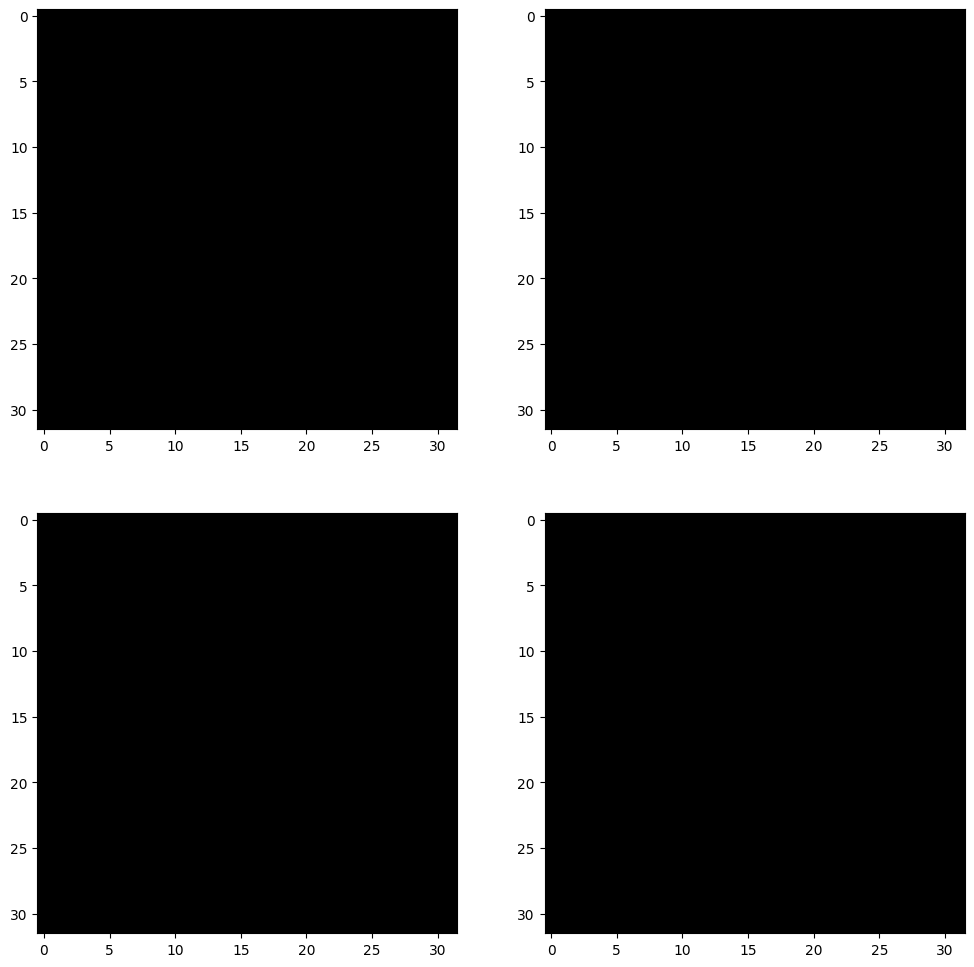

In [21]:
#Inference

#x = torch.randn(4, 1, 32, 32).to(device) 
x = torch.randint(0, 2, (4, 1, 32, 32), device=device).float()
inferenceSteps = torch.linspace(trainSteps-1, 0, 100, device=device)

for t in tqdm(inferenceSteps):
    with torch.no_grad():
        pred = model(x, t).sample
        
    # Update sample with step
    x = denoise(pred, t.to('cpu').long(), x)

# argmax_images = torch.argmax(x, dim=1, keepdim=True)
# Show the results
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(x[0,0].cpu(), cmap='gray')
axs[0, 1].imshow(x[1,0].cpu(), cmap='gray')
axs[1, 0].imshow(x[2,0].cpu(), cmap='gray')
axs[1, 1].imshow(x[3,0].cpu(), cmap='gray')


plt.show()

100%|██████████| 5/5 [00:00<?, ?it/s]


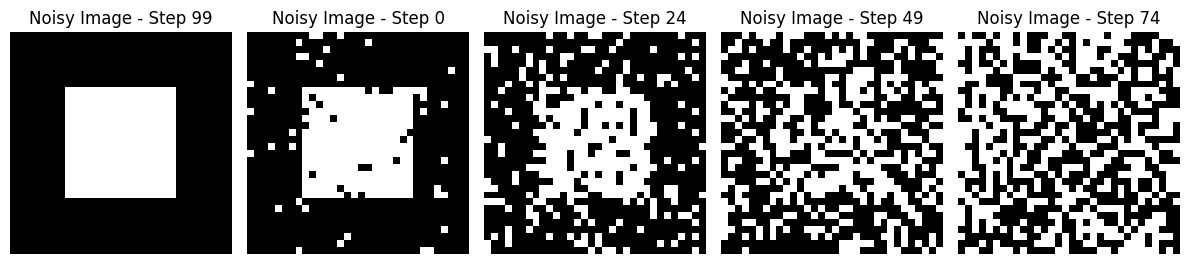

In [11]:
# Visualize to make sure binomial noise is working correctly

pureImage = image[0:1]#.float()
num_samples = 5
inferenceSteps = torch.linspace(0, trainSteps-1, num_samples)
noisy_images = []

for t in tqdm(inferenceSteps):
    noisyImage, noise = addBernouliNoise(pureImage, t.long())
    noisy_images.append(noisyImage)

fig, axes = plt.subplots(1, num_samples , figsize=(12, 4))

# Display each noisy image
for i, noisyImage in enumerate(noisy_images):
    axes[i].imshow(noisyImage.detach().cpu().numpy().squeeze(), cmap='gray')
    axes[i].set_title(f'Noisy Image - Step {int(inferenceSteps[i-1])}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

STOP, Remake above this line
-------

In [2]:
#NOTE

# Create a categorical distribution
#dist = torch.distributions.Categorical(probs)

In [2]:
# While training, numbers are fine. These can afterwards be paired to ie. specific colors of wool + air
blockList = [
    0, 1, # 2, 3, 4, 5, 6, 7, 8, 9, 10
]

In [4]:
# Things that should only run once

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

mnist_dataset = datasets.load_dataset('mnist', split='train')

# Define a PyTorch Dataset class
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy
            image.resize((32, 32))  # Resize to 32x32 # I had an error with running the unet, and changing the size fixed it.

        # Convert NumPy array to PyTorch tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0,1]
        image = torch.round(image)

        # Add the image as a specific channel
        multi_channel_image = torch.zeros(len(blockList), 32, 32)
        #multi_channel_image[item['label'] + 1] = image
        multi_channel_image[1] = image
        multi_channel_image[0] = -(image - 1 )
        
        # Convert label to a tensor
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return multi_channel_image, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(mnist_dataset)
trainDataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

Using device: cuda


In [5]:
class BinomialDiffusionScheduler():
    def __init__(self, num_train_timesteps=100, beta_start=0.0001, beta_end=0.02, device='???'):
        with torch.no_grad():
            self.num_train_timesteps = num_train_timesteps
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, device='cpu')  # Diffusion rates
            self.alphas = 1.0 - self.betas
            self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)  # Cumulative product for timestep t

    def add_noise(self, x, t):
        """Forward diffusion using a binomial distribution."""
        with torch.no_grad():
            alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)  # Shape for broadcasting

            noise = torch.randint(0, 2, x.shape, device=x.device)  # Binomial noise

            print(f"alpha_t device: {alpha_t.device}")
            print(f"noise device: {noise.device}")
            print(f"x device: {x.device}")
            
            probs = alpha_t * x + (1 - alpha_t) * noise

            return torch.bernoulli(probs), noise  # Sample from the binomial distribution

    def step(self, model_output, t, x_t):
        """Reverse step using predicted logits."""
        # Convert model output (logits) to probabilities
        probs = torch.softmax(model_output, dim = 1)
        
        # Sample from the predicted binomial distribution
        x_prev = torch.bernoulli(probs)
        
        return x_prev

    def set_timesteps(self, num_inference_steps):
        self.timesteps = torch.linspace(0, self.num_train_timesteps - 1, num_inference_steps).long()


#noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_schedule='squaredcos_cap_v2')
noise_scheduler = BinomialDiffusionScheduler(device=device)

In [6]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, numlabels, numblocks):
    super().__init__()
    
    self.numlabels = numlabels
    self.numblocks = numblocks

    self.guidance_prob = 0.1

    #Added an extra depth
    self.model = UNet2DModel(
        sample_size=32,          
        in_channels=numblocks + numlabels, 
        out_channels=numblocks,     
        layers_per_block=2,     
        block_out_channels=(64, 128, 128), 
        down_block_types=( 
            "DownBlock2D",    
            "DownBlock2D",   
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "UpBlock2D",   
            "UpBlock2D",        
          ),
    )

  def classCondition(self, class_labels, shape):
    bs, ch, w, h = shape
    class_cond = F.one_hot(class_labels, num_classes=self.numlabels).float()  # Shape: (bs, blockLen)
    batch_size, embed_dim = class_cond.shape
    mask = torch.rand(batch_size, device=class_cond.device) < self.guidance_prob
    class_cond[mask] = torch.zeros(embed_dim, device=class_cond.device)
    return class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    #return class_cond.view(bs, self.numlabels, 1, 1).expand(bs, 10, w, h)  # (bs, 10, w, h)

  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape

    class_cond = self.classCondition(class_labels, x.shape)
    # Concatenate along channel dimension
    net_input = torch.cat((x, class_cond), dim=1)  

    return self.model(net_input, t).sample 

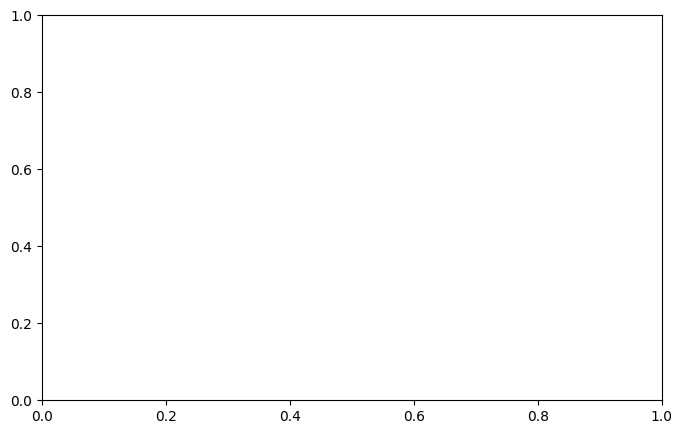

  0%|          | 0/469 [00:00<?, ?it/s]

alpha_t device: cpu
noise device: cpu
x device: cpu


RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

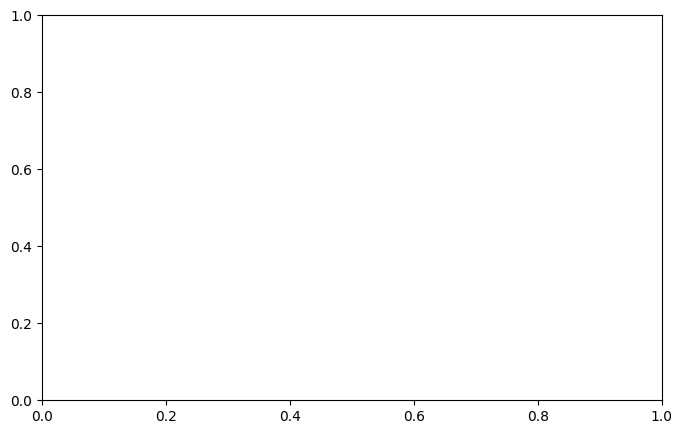

In [8]:
n_epochs = 5

net = ClassConditionedUnet(10, len(blockList)).to(device) #10 labels
opt = torch.optim.Adam(net.parameters(), lr=1e-4) 

trainingSteps = noise_scheduler.num_train_timesteps

# class MSEPerChannelSum(nn.Module):
#     def forward(self, X_pred, X_true):
#         squared_errors = (X_pred - X_true) ** 2  # Squared differences
#         mean_per_channel = squared_errors.mean(dim=[0, 2, 3])  # Mean per channel
#         return mean_per_channel.sum()  # Sum over all channels
    
loss_fn = nn.MSELoss()

losses = []
fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

for epoch in range(n_epochs):
    batchNum = 0
    for image, label in tqdm(trainDataloader):
        image = image.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        label = label.to(device)

        timesteps = torch.randint(0, trainingSteps - 1, (image.shape[0],), device=device).long()
        noisy_image, noise = noise_scheduler.add_noise(image.to('cpu'), timesteps.to('cpu')).to(device)

        pred = net(noisy_image, timesteps, label)
        #loss = loss_fn(pred, noise) # How close is the output to the noise
        loss = torch.nn.functional.cross_entropy(noise, pred.argmax(dim=1))

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    clear_output(wait=True)  
    ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    display(fig)

200it [00:07, 25.38it/s]


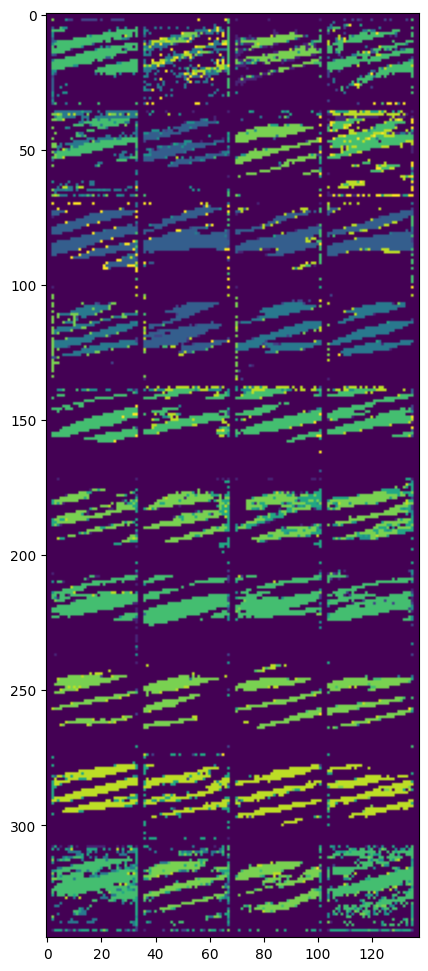

In [ ]:
x = torch.randn(40, 11, 32, 32).to(device) 
labels = torch.tensor([[i]*4 for i in range(10)]).flatten().to(device)
noise_scheduler.set_timesteps(200)

y_uncond = torch.zeros_like(labels) # unconditional samples

guidance_scale = 7.5

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

        # Get model pred
    with torch.no_grad():
        # Get unconditioned and conditioned predictions
        residual_uncond = net(x, t, y_uncond)  # Without conditioning
        residual_cond = net(x, t, labels)           # With conditioning
        
        # Apply CFG: interpolate between uncond & cond
        residual = residual_uncond + guidance_scale * (residual_cond - residual_uncond)

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

argmax_images = torch.argmax(x, dim=1, keepdim=True)
# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(argmax_images.detach().cpu(), nrow=4)[0])